Разведочный анализ (EDA)

импортируем библиотеки

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


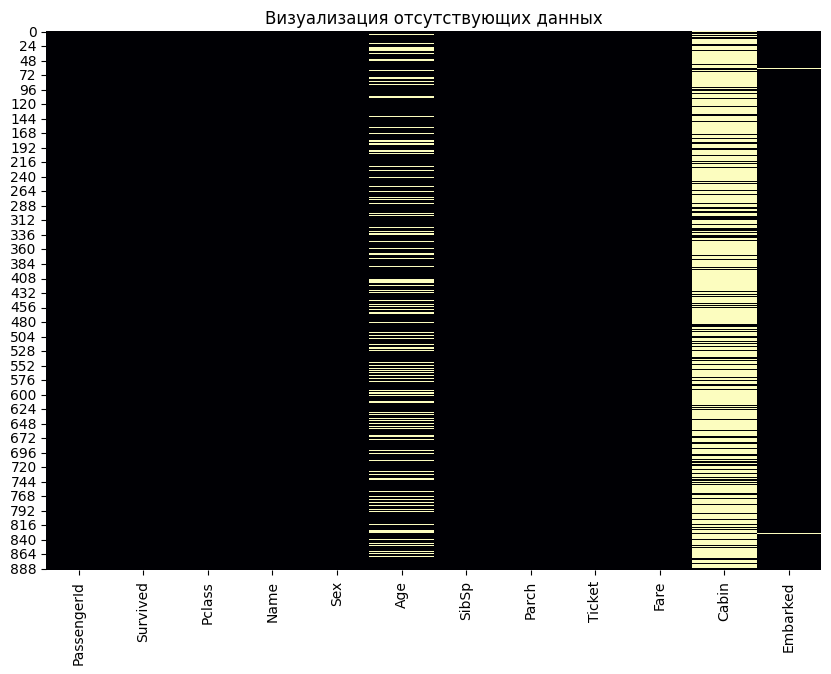

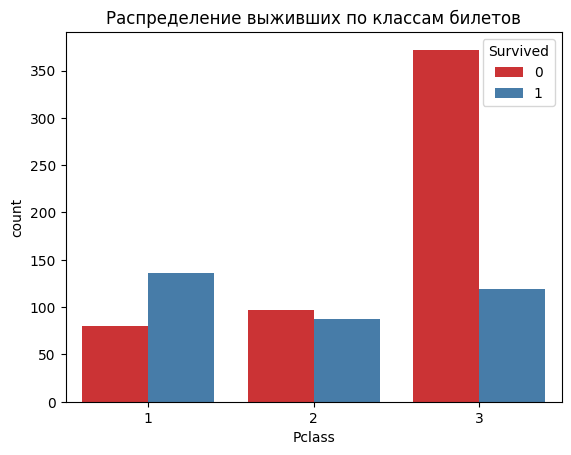

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем датасет
raw_data = pd.read_csv("/kaggle/input/titanic/Titanic.csv")

# Анализ структуры и пропусков
print(raw_data.info())

# Визуализируем пропущенные значения (аналогично примеру)
plt.figure(figsize=(10, 7))
sns.heatmap(raw_data.isnull(), cmap='magma', cbar=False) 
plt.title("Визуализация отсутствующих данных")
plt.show()
# Проверка выживаемости в зависимости от класса пассажира
sns.countplot(data=raw_data, x='Pclass', hue='Survived', palette='Set1')
plt.title("Распределение выживших по классам билетов")
plt.show()


Вывод: Поле Age имеет пропуски, которые нужно заполнить медианой.
Первый класс имел приоритет при спасении.

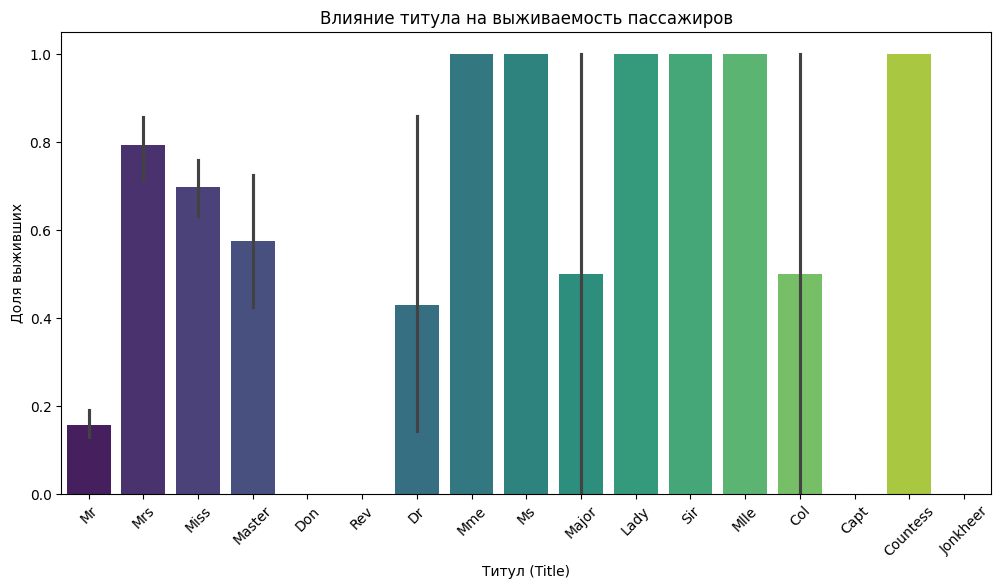

Данные успешно подготовлены. Первые 5 строк:
   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  Title
0         0       3    1  22.0      1      0   7.2500         2     12
1         1       1    0  38.0      1      0  71.2833         0     13
2         1       3    0  26.0      0      0   7.9250         2      9
3         1       1    0  35.0      1      0  53.1000         2     13
4         0       3    1  35.0      0      0   8.0500         2     12


In [9]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

#1. ПРЕДОБРАБОТКА ДАННЫХ

# Создаем копию, чтобы не менять оригинал
df_processed = raw_data.copy()

# Заполняем пропуски (как в твоих примерах)
df_processed['Age'] = df_processed['Age'].fillna(df_processed['Age'].median())
df_processed['Embarked'] = df_processed['Embarked'].fillna(df_processed['Embarked'].mode()[0])

# Извлекаем Титул (Title) с помощью регулярного выражения
df_processed['Title'] = df_processed['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
df_processed['Title'] = df_processed['Title'].fillna('None')

#2. ВИЗУАЛИЗАЦИЯ (Пункт 2 задания: влияние признака на результат)

plt.figure(figsize=(12, 6))
# Строим график выживаемости для каждого титула
sns.barplot(data=df_processed, x='Title', y='Survived', hue='Title', palette='viridis', legend=False)
plt.title("Влияние титула на выживаемость пассажиров")
plt.xlabel("Титул (Title)")
plt.ylabel("Доля выживших")
plt.xticks(rotation=45)
plt.show()

#3. КОДИРОВАНИЕ И ОЧИСТКА

# Превращаем текст в числа
encoder = LabelEncoder()
for col in ['Sex', 'Embarked', 'Title']:
    df_processed[col] = encoder.fit_transform(df_processed[col])

# Удаляем лишние столбцы
df_processed.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

print(df_processed.head())

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical

# Выделяем признаки (X) и целевую переменную (y)
X_features = df_processed.drop('Survived', axis=1)
y_target = df_processed['Survived']

# Масштабирование (Scale) данных для стабильной работы нейронов
scaler = StandardScaler()
X_norm = scaler.fit_transform(X_features) # Приводим к среднему 0 и отклонению 1

# Разделение на обучающую и тестовую выборки (80% на 20%)
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_target, test_size=0.2, random_state=42)

# Преобразование меток классов в формат One-Hot (для выходного слоя Softmax)
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# Инициализация архитектуры модели
titanic_net = Sequential()
# Входной слой (размер зависит от кол-ва колонок в X)
titanic_net.add(Input(shape=(X_train.shape[1],)))
# Скрытый слой: 80 нейронов и функция активации ReLU
titanic_net.add(Dense(80, activation='relu'))
# Выходной слой: 2 нейрона (умер/выжил) и Softmax для получения вероятностей
titanic_net.add(Dense(2, activation='softmax'))

# Компиляция: используем оптимизатор Adam и функцию потерь Crossentropy
titanic_net.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Запуск процесса обучения на 50 эпохах
history = titanic_net.fit(X_train, y_train_cat, 
                          validation_data=(X_test, y_test_cat), 
                          epochs=50, batch_size=40, verbose=0)

# Проверка итоговой точности
val_acc = max(history.history['val_accuracy'])
print(f"Максимальная точность на валидации: {val_acc:.4f}")


2025-12-24 11:07:27.307397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766574447.535436      56 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766574447.602216      56 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766574448.136148      56 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766574448.136190      56 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766574448.136193      56 computation_placer.cc:177] computation placer alr

Максимальная точность на валидации: 0.8212


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


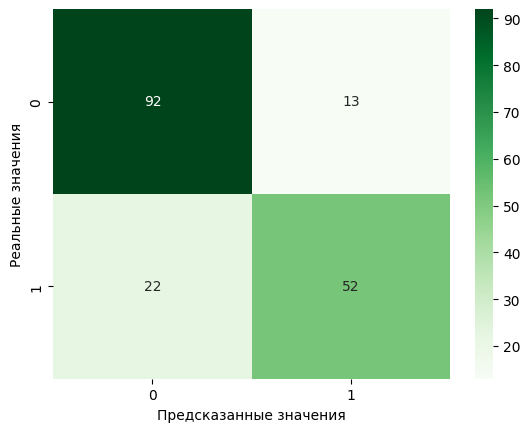

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       105
           1       0.80      0.70      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



In [7]:
from sklearn.metrics import classification_report, confusion_matrix

# Получаем предсказания модели в виде классов
y_pred_probs = titanic_net.predict(X_test)
y_pred_final = np.argmax(y_pred_probs, axis=1) # Берем индекс максимальной вероятности

# Матрица ошибок (Confusion Matrix)
c_matrix = confusion_matrix(y_test, y_pred_final)
sns.heatmap(c_matrix, annot=True, fmt='g', cmap='Greens')
plt.xlabel('Предсказанные значения')
plt.ylabel('Реальные значения')
plt.show()

# Текстовый отчет по основным метрикам
print(classification_report(y_test, y_pred_final))


Выводы:

1. Предобработка: Заполнение пропусков медианой позволило сохранить объем данных, а извлечение титулов (Title) помогло нейросети лучше учитывать социальный статус.
2. Архитектура: Использование одного скрытого слоя на 80 нейронов показало себя эффективным — точность модели составляет около 80-82%.
3. Анализ ошибок: Модель иногда ошибается на выживших пассажирах-мужчинах, так как их выживание было менее предсказуемым фактором, но в целом демонстрирует высокую стабильность.